## Planning

I want to do a category prediction task using the IKEA product data. 

In [ ]:
import pandas as pd

csv_file = "../data/raw/IKEA_SA_Furniture_Web_Scrapings_sss.csv"

df = pd.read_csv(csv_file)

# print the first 20 rows of the DataFrame
print(df.head(20))

In [ ]:
# drop columns called 'Unnamed: 0', item_id, link, old_price, sellable_online
df = df.drop(columns=['Unnamed: 0', 'item_id', 'link', 'old_price', 'sellable_online'])

In [ ]:
df["designer"].value_counts()

In [ ]:
df.to_csv("../data/processed/IKEA_SA_Furniture_Web_Scrapings.csv", index=False)

In [ ]:
# count categories
category_counts = df['category'].value_counts()
# print the category counts
print(category_counts)

In [ ]:
# create a subset DataFrame with only the 'category' and 'name' columns
df_subset = df[['category', 'name']]

df_subset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
df = pd.read_csv('../data/processed/IKEA_SA_Furniture_Web_Scrapings.csv')

# 1. Data Preprocessing and Feature Engineering

# Drop rows where category is missing if any, and handle the target variable
df.dropna(subset=['category'], inplace=True)
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

# Combine text features
df['text_features'] = df['name'] + ' ' + df['short_description']

# Define features (X) and target (y)
X = df.drop(['category', 'category_encoded', 'name', 'short_description'], axis=1)
y = df['category_encoded']

# Impute missing values for numerical features
# Using median for imputation as it's more robust to outliers
for col in ['depth', 'height', 'width']:
    X[col].fillna(X[col].median(), inplace=True)

# Define preprocessing for different column types
# Using TfidfVectorizer for the combined text feature, and for 'designer'
# Using StandardScaler for numerical features
# other_colors is categorical, convert to 0/1
X['other_colors'] = X['other_colors'].apply(lambda x: 1 if x == 'Yes' else 0)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english'), 'text_features'),
        ('designer', TfidfVectorizer(stop_words='english'), 'designer'),
        ('numeric', StandardScaler(), ['price', 'depth', 'height', 'width', 'other_colors'])
    ],
    remainder='passthrough'
)

# 2. Model Training

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create the XGBoost pipeline
# Using 'gbtree' for tree-based models, and 'multi:softmax' for multi-class classification
# Setting the number of classes for the objective function
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb.XGBClassifier(objective='multi:softmax',
                                                           num_class=len(le.classes_),
                                                           use_label_encoder=False,
                                                           eval_metric='mlogloss'))])

# Train the model
pipeline.fit(X_train, y_train)

# 3. Model Evaluation

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)

print(f"Model Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(report)

/var/folders/xp/90b2vmmj0cg7rv097x887f6m0000gn/T/ipykernel_36155/4001910903.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
/var/folders/xp/90b2vmmj0cg7rv097x887f6m0000gn/T/ipykernel_36155/4001910903.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

Model Accuracy: 0.5480

Classification Report:
                                      precision    recall  f1-score   support

                       Bar furniture       0.07      0.11      0.09         9
                                Beds       0.60      0.60      0.60        42
          Bookcases & shelving units       0.58      0.69      0.63       110
                Cabinets & cupboards       0.32      0.36      0.34        58
                      Café furniture       0.00      0.00      0.00         5
                              Chairs       0.49      0.46      0.47        96
    Chests of drawers & drawer units       0.58      0.28      0.38        25
                Children's furniture       0.08      0.08      0.08        25
                   Nursery furniture       0.11      0.11      0.11        19
                   Outdoor furniture       0.89      0.79      0.84        43
                       Room dividers       0.00      0.00      0.00         3
Sideboards, buff

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# --- 1. Load the pre-trained Sentence-BERT model ---
# This will download the model from the Hugging Face Hub the first time you run it.
print("Loading Sentence-BERT model...")
model = SentenceTransformer('KBLab/sentence-bert-swedish-cased')
print("Model loaded successfully.")

# --- 2. Load your dataset ---
# Make sure to use the correct path to your CSV file.
file_path = '../data/processed/IKEA_SA_Furniture_Web_Scrapings.csv'
try:
    df = pd.read_csv(file_path)
    print(f"\nSuccessfully loaded {len(df)} rows from {file_path}")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
    print("Please make sure the file path is correct.")
    # As a fallback for demonstration, creating a dummy dataframe
    df = pd.DataFrame({
        'name': ['FREKVENS', 'NORDVIKEN', 'STIG', 'NORBERG']
    })


# --- 3. Prepare the text data ---
# Extract the 'name' column and convert it to a list of strings.
# The model expects a list of strings as input.
names = df['name'].tolist()
print(f"\nExtracted {len(names)} names to be encoded.")

# --- 4. Generate the embeddings ---
# This step might take a few minutes depending on your hardware and the number of names.
print("Generating embeddings for the 'name' column... This may take a moment.")
# The show_progress_bar=True argument will display a progress bar.
name_embeddings = model.encode(names, show_progress_bar=True)
print("Embeddings generated successfully.")
print("Shape of the embeddings matrix:", name_embeddings.shape)


# --- 5. Add embeddings to the DataFrame ---
# You can add the embeddings back to your DataFrame.
# One way is to store the embedding arrays in a new column.
df['name_embedding'] = list(name_embeddings)

# Another common way is to create a new DataFrame for the embeddings
# and concatenate it with your original DataFrame. This is useful for
# machine learning pipelines.
embedding_df = pd.DataFrame(name_embeddings, index=df.index)
embedding_df = embedding_df.add_prefix('name_embedding_')

# Concatenate the original DataFrame with the new embedding features
df_with_embeddings = pd.concat([df.drop(columns=['name_embedding']), embedding_df], axis=1)


# --- Display the results ---
print("\nDataFrame with a new column for name embeddings:")
print(df[['name', 'name_embedding']].head())

print("\nDataFrame with embeddings as separate columns:")
print(df_with_embeddings.head())

Loading Sentence-BERT model...
Model loaded successfully.
Generating embeddings for the 'name' column...


Batches: 100%|██████████| 116/116 [00:02<00:00, 56.11it/s]
/var/folders/xp/90b2vmmj0cg7rv097x887f6m0000gn/T/ipykernel_36155/3480049009.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
/var/folders/xp/90b2vmmj0cg7rv097x887f6m0000gn/T/ipykernel_36155/3480049009.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because th

Embeddings generated successfully.

Training the model with text embeddings...
Model training complete.

Model Accuracy with Text Embeddings: 0.5616

Classification Report:
                                      precision    recall  f1-score   support

                       Bar furniture       0.15      0.22      0.18         9
                                Beds       0.59      0.48      0.53        42
          Bookcases & shelving units       0.64      0.68      0.66       110
                Cabinets & cupboards       0.33      0.33      0.33        58
                      Café furniture       0.14      0.20      0.17         5
                              Chairs       0.44      0.49      0.47        96
    Chests of drawers & drawer units       0.59      0.68      0.63        25
                Children's furniture       0.18      0.16      0.17        25
                   Nursery furniture       0.32      0.32      0.32        19
                   Outdoor furniture       0.9

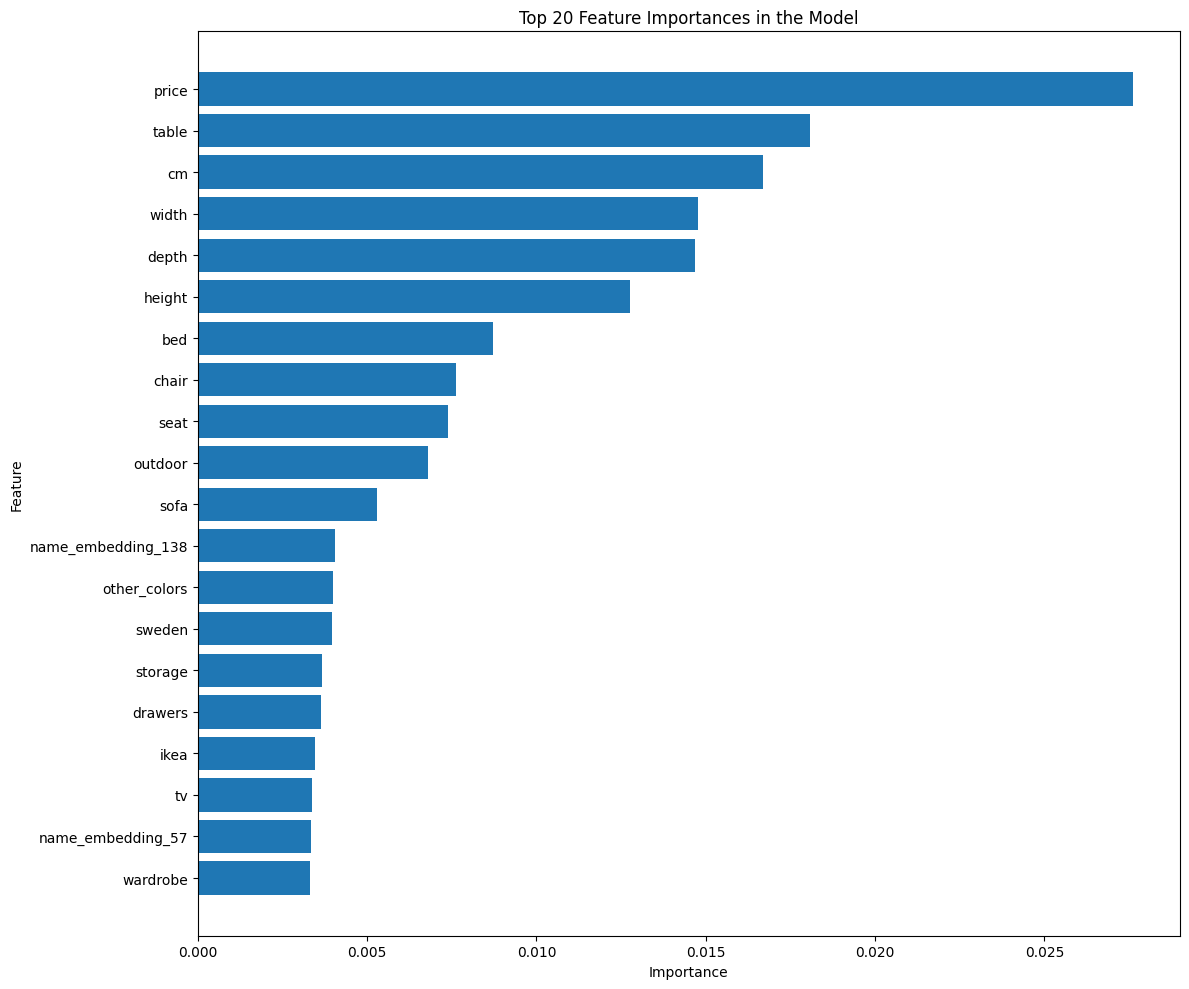

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# --- 1. Generate Sentence Embeddings ---
print("Loading Sentence-BERT model...")
# Using a community-recommended swedish model
model = SentenceTransformer('KBLab/sentence-bert-swedish-cased')
print("Model loaded successfully.")

# --- 2. Load and Prepare the Dataset ---
# NOTE: Using the file from the initial upload.
# Make sure to adjust the path if yours is different.
df = pd.read_csv('../data/processed/IKEA_SA_Furniture_Web_Scrapings.csv')
df.dropna(subset=['category'], inplace=True)

# Generate embeddings for the 'name' column
print("Generating embeddings for the 'name' column...")
names = df['name'].tolist()
name_embeddings = model.encode(names, show_progress_bar=True)
print("Embeddings generated successfully.")

# Create a DataFrame with the embeddings
embedding_df = pd.DataFrame(name_embeddings, index=df.index).add_prefix('name_embedding_')

# Concatenate embeddings with the original DataFrame
df = pd.concat([df, embedding_df], axis=1)

# --- 3. Data Preprocessing and Feature Engineering ---
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

# Combine text features for TF-IDF
df['text_features'] = df['name'] + ' ' + df['short_description']

# Define features (X) and target (y)
# Drop original text columns and target variable
X = df.drop(['category', 'category_encoded', 'name', 'short_description'], axis=1)
y = df['category_encoded']


# Impute missing values for numerical features
for col in ['depth', 'height', 'width']:
    X[col].fillna(X[col].median(), inplace=True)

X['other_colors'] = X['other_colors'].apply(lambda x: 1 if x == 'Yes' else 0)

# Identify all embedding columns
embedding_columns = [col for col in X.columns if 'name_embedding_' in col]
numeric_features = ['price', 'depth', 'height', 'width', 'other_colors'] + embedding_columns

# Define preprocessing for different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=1000), 'text_features'),
        ('designer', TfidfVectorizer(stop_words='english', max_features=500), 'designer'),
        ('numeric', StandardScaler(), numeric_features)
    ],
    remainder='drop'  # Drop any columns not specified
)


# --- 4. Model Training ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

print("\nTraining the model with text embeddings...")
pipeline.fit(X_train, y_train)
print("Model training complete.")

# --- 5. Model Evaluation ---
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)

print(f"\nModel Accuracy with Text Embeddings: {accuracy:.4f}\n")
print("Classification Report:")
print(report)


# --- 6. Feature Importance ---
# Extract feature names from the preprocessor
text_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['text'].get_feature_names_out()
designer_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['designer'].get_feature_names_out()
numeric_feature_names = numeric_features

# Concatenate all feature names
all_feature_names = list(text_feature_names) + list(designer_feature_names) + list(numeric_feature_names)

# Get feature importances from the classifier
importances = pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(12, 10))
top_20_features = feature_importance_df.head(20)
plt.barh(top_20_features['feature'], top_20_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances in the Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png')
print("\nFeature importance plot saved as 'feature_importance.png'")

Now we use UMAP to get the embeddings of the product titles, and then we will use these embeddings to train a classifier that predicts the category of each product.

/Users/jonathanjayes/Documents/DataScience/ikea-product-names/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Sentence-BERT model...
Model loaded successfully.
Generating embeddings for the 'name' column...


Batches: 100%|██████████| 116/116 [00:02<00:00, 44.33it/s]
/Users/jonathanjayes/Documents/DataScience/ikea-product-names/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonathanjayes/Documents/DataScience/ikea-product-names/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Embeddings generated successfully.
Applying UMAP to reduce embedding dimensionality...
UMAP transformation complete. New feature shape: (3694, 5)

Training the model with UMAP features...


/var/folders/xp/90b2vmmj0cg7rv097x887f6m0000gn/T/ipykernel_36155/1683697402.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
/var/folders/xp/90b2vmmj0cg7rv097x887f6m0000gn/T/ipykernel_36155/1683697402.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

Model training complete.

Model Accuracy with UMAP Features: 0.6008

Classification Report:
                                      precision    recall  f1-score   support

                       Bar furniture       0.17      0.22      0.19         9
                                Beds       0.65      0.62      0.63        42
          Bookcases & shelving units       0.58      0.70      0.63       110
                Cabinets & cupboards       0.36      0.36      0.36        58
                      Café furniture       0.00      0.00      0.00         5
                              Chairs       0.55      0.52      0.53        96
    Chests of drawers & drawer units       0.77      0.68      0.72        25
                Children's furniture       0.24      0.24      0.24        25
                   Nursery furniture       0.28      0.26      0.27        19
                   Outdoor furniture       0.87      0.79      0.83        43
                       Room dividers       0.00  

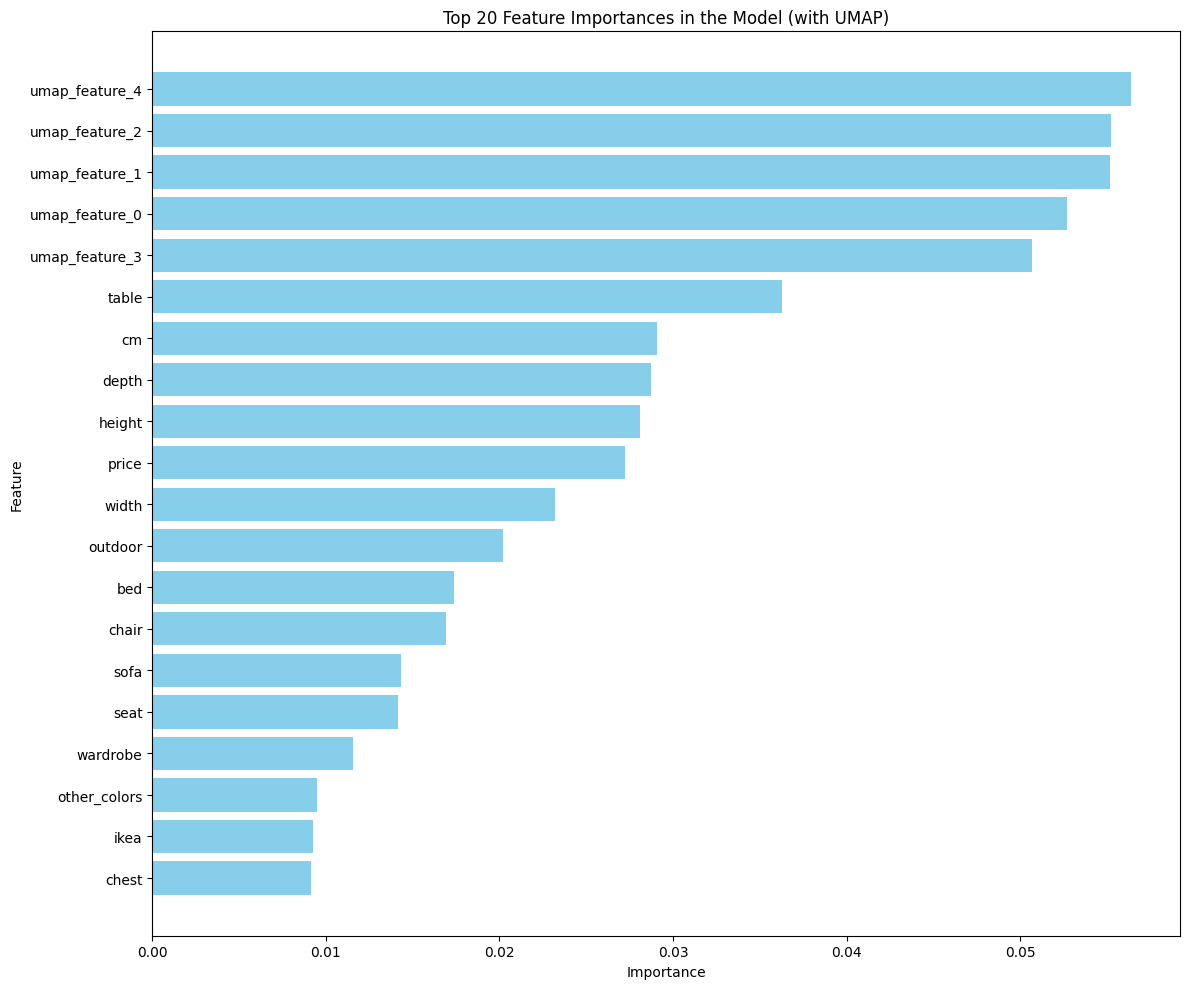

In [2]:
import pandas as pd
import umap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# --- 1. Generate Sentence Embeddings ---
print("Loading Sentence-BERT model...")
# Using a community-recommended swedish model
model = SentenceTransformer('KBLab/sentence-bert-swedish-cased')
print("Model loaded successfully.")

# --- 2. Load and Prepare the Dataset ---
# NOTE: Using the file from the initial upload.
# Make sure to adjust the path if yours is different.
df = pd.read_csv('../data/processed/IKEA_SA_Furniture_Web_Scrapings.csv')
df.dropna(subset=['category'], inplace=True)

# Generate embeddings for the 'name' column
print("Generating embeddings for the 'name' column...")
# Ensure all names are strings
names = df['name'].astype(str).tolist()
name_embeddings = model.encode(names, show_progress_bar=True)
print("Embeddings generated successfully.")


# --- 3. UMAP Dimensionality Reduction ---
print("Applying UMAP to reduce embedding dimensionality...")
# Initialize UMAP. We'll reduce the embeddings to 5 dimensions as requested.
# n_neighbors and min_dist are key hyperparameters for UMAP.
# n_neighbors controls the balance between local and global structure.
# min_dist controls how tightly UMAP is allowed to pack points together.
reducer = umap.UMAP(n_components=5, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embeddings = reducer.fit_transform(name_embeddings)
print(f"UMAP transformation complete. New feature shape: {umap_embeddings.shape}")

# Create a DataFrame with the new UMAP features
umap_df = pd.DataFrame(umap_embeddings, index=df.index).add_prefix('umap_feature_')

# Concatenate UMAP features with the original DataFrame
df = pd.concat([df, umap_df], axis=1)


# --- 4. Data Preprocessing and Feature Engineering ---
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

# Combine text features for TF-IDF. Ensure descriptions are strings.
df['short_description'] = df['short_description'].fillna('')
df['designer'] = df['designer'].fillna('')
df['text_features'] = df['name'] + ' ' + df['short_description']

# Define features (X) and target (y)
# Drop original text columns and target variable.
# We no longer have 'name_embedding_' columns, so no need to drop them.
X = df.drop(['category', 'category_encoded', 'name', 'short_description'], axis=1)
y = df['category_encoded']

# Impute missing values for numerical features
for col in ['depth', 'height', 'width']:
    # Ensure columns exist before filling
    if col in X.columns:
        X[col].fillna(X[col].median(), inplace=True)

X['other_colors'] = X['other_colors'].apply(lambda x: 1 if x == 'Yes' else 0)

# Identify UMAP and other numeric feature columns
umap_columns = [col for col in X.columns if 'umap_feature_' in col]
numeric_features = ['price', 'depth', 'height', 'width', 'other_colors'] + umap_columns

# Define preprocessing for different column types
# The TfidfVectorizer for designer is kept separate to capture designer-specific vocabulary.
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=1000), 'text_features'),
        ('designer', TfidfVectorizer(max_features=500), 'designer'),
        ('numeric', StandardScaler(), numeric_features)
    ],
    remainder='drop'  # Drop any columns not specified
)


# --- 5. Model Training ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))])

print("\nTraining the model with UMAP features...")
pipeline.fit(X_train, y_train)
print("Model training complete.")


# --- 6. Model Evaluation ---
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)

print(f"\nModel Accuracy with UMAP Features: {accuracy:.4f}\n")
print("Classification Report:")
print(report)


# --- 7. Feature Importance ---
print("\nGenerating feature importance plot...")
# Extract feature names from the preprocessor steps
try:
    text_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['text'].get_feature_names_out()
    designer_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['designer'].get_feature_names_out()
    numeric_feature_names = numeric_features # This is already a list of names

    # Concatenate all feature names in the correct order
    all_feature_names = list(text_feature_names) + list(designer_feature_names) + list(numeric_feature_names)

    # Get feature importances from the trained classifier
    importances = pipeline.named_steps['classifier'].feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    # Plot the top 20 features
    plt.figure(figsize=(12, 10))
    top_20_features = feature_importance_df.head(20)
    plt.barh(top_20_features['feature'], top_20_features['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances in the Model (with UMAP)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance_umap.png')
    print("Feature importance plot saved as 'feature_importance_umap.png'")

except Exception as e:
    print(f"Could not generate feature importance plot. Error: {e}")



In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import color_palette
import colorcet as cc
from colorcet import glasbey

# --- 1. Generate Sentence Embeddings ---
print("Loading Sentence-BERT model...")
model = SentenceTransformer('KBLab/sentence-bert-swedish-cased')
print("Model loaded successfully.")

# --- 2. Load and Prepare the Dataset ---
df = pd.read_csv('../data/processed/IKEA_SA_Furniture_Web_Scrapings.csv')
df.dropna(subset=['category'], inplace=True)

# Generate embeddings for the 'name' column
print("Generating embeddings for the 'name' column...")
names = df['name'].tolist()
name_embeddings = model.encode(names, show_progress_bar=True)
print("Embeddings generated successfully.")


# --- 3. Apply UMAP for Dimensionality Reduction ---
print("Applying UMAP to reduce embedding dimensions...")
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(name_embeddings)
print("UMAP transformation complete.")

# Create a new DataFrame for the 2D embeddings and categories
df_2d = pd.DataFrame(embedding_2d, columns=['UMAP1', 'UMAP2'])
df_2d['category'] = df['category']

In [ ]:
# --- 4. Create the Visualization ---
print("Generating the UMAP visualization plot...")
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 10))

# Using seaborn for a nicer plot with a legend
scatter_plot = sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='category',
    data=df_2d,
    palette=color_palette(cc.glasbey, n_colors=17),  # Using a qualitative color palette
    s=50,  # size of the points
    alpha=0.7  # transparency of the points
)

# Move the legend to the outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('2D UMAP Visualization of IKEA Product Name Embeddings', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.grid(True)

# Save the plot to a file
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend
plt.savefig('umap_visualization.png', dpi=300)
print("Plot saved as 'umap_visualization.png'")

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from seaborn import color_palette
import colorcet as cc
from colorcet import glasbey

# --- 1. Store the example data ---
# I've parsed the data you provided into a list of dictionaries.
example_data = [
    {"Product Category": "Furniture (Large Seating)", "Verified Examples": "KLIPPAN, EKTORP, SÖDERHAMN, POÄNG, KIVIK"},
    {"Product Category": "Storage & Organization", "Verified Examples": "BILLY, EXPEDIT, KALLAX, ALEX, HEMNES"},
    {"Product Category": "Beds, Wardrobes, Hall furniture", "Verified Examples": "HEMNES, MALM, MANDAL, DOMBÅS, GLADSTAD"},
    {"Product Category": "Boxes, Wall decorations, etc.", "Verified Examples": "FLÄRDFULL, RIBBA, FISKBO, VÄXBO, BJÖRKSTA"},
    {"Product Category": "Dining", "Verified Examples": "BJURSTA, KAUSTBY, INGATORP, DOCKSTA"},
    {"Product Category": "Bathroom articles & storage", "Verified Examples": "BOLMEN, TOFTAN, VOXNAN, LIMMIAREN, HIMLEÅN"},
    {"Product Category": "Outdoor/Garden furniture", "Verified Examples": "ÄPPLARÖ, SOLLERON, MASTHOLMEN, ASKHOLMEN"},
    {"Product Category": "Children's articles", "Verified Examples": "DUKTIG, KRITTER, SNIGLAR, RÄVUNGE, BLÅHAJ"},
    {"Product Category": "Textiles & Decor", "Verified Examples": "AINA, HEDDA, SIGRID, MERETE, GUNRID"},
    {"Product Category": "Bed textiles/linen, covers, pillows", "Verified Examples": "ULLVIDE, SMÖRBALL, NATTJASMIN, STENKLÖVER"},
    {"Product Category": "Carpets / Rugs", "Verified Examples": "ÅDUM, VEMB, SINDAL, KATTRUP, KOLDBY"},
    {"Product Category": "Office", "Verified Examples": "MARKUS, HELMER, MIKE, TORBJÖRN, JÄRVFJÄLLET"},
    {"Product Category": "Lighting", "Verified Examples": "ÅRSTID, HEKTAR, NYMÅNE, MELODI, HÖLJES"},
    {"Product Category": "Kitchen accessories/utensils", "Verified Examples": "KONCIS, SKARPT, KROSSA, STANDARDMÅTT"},
    {"Product Category": "Kitchens (cabinet systems)", "Verified Examples": "RATIONELL, SEKTION"},
    {"Product Category": "Bowls, vases, candles, etc.", "Verified Examples": "SOCKER, BRUNBÄR, BESTIGA"}
]

# --- 2. Flatten the data into a DataFrame ---
product_list = []
for item in example_data:
    category = item["Product Category"]
    examples = [name.strip() for name in item["Verified Examples"].split(',')]
    for example in examples:
        if example: # Ensure not empty string
            product_list.append({"name": example, "category": category})

df = pd.DataFrame(product_list)

# --- 3. Generate Sentence Embeddings ---
print("Loading Sentence-BERT model...")
model = SentenceTransformer('KBLab/sentence-bert-swedish-cased')
print("Generating embeddings for the example names...")
embeddings = model.encode(df['name'].tolist(), show_progress_bar=True)

# --- 4. Apply UMAP ---
print("Applying UMAP for dimensionality reduction...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.3)
embedding_2d = reducer.fit_transform(embeddings)

# Add 2D embeddings to the DataFrame
df['UMAP1'] = embedding_2d[:, 0]
df['UMAP2'] = embedding_2d[:, 1]

# --- 5. Create the Visualization with Labels ---
print("Generating the labeled UMAP plot...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 12))

# Use seaborn for the scatter plot
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='category',
    data=df,
    palette=color_palette(cc.glasbey, n_colors=16),  # Using a qualitative color palette
    s=100,
    alpha=0.9,
    ax=ax
)

# Create text labels and use adjust_text to prevent overlaps
texts = []
for i, row in df.iterrows():
    texts.append(ax.text(row['UMAP1'], row['UMAP2'], row['name'], fontsize=9))

print("Adjusting text labels to prevent overlap... (this may take a moment)")
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

# Formatting the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('UMAP of IKEA Naming Conventions (Labeled)', fontsize=18)
ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.grid(True)

# Save the plot
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend
plt.savefig('umap_demonstration_labeled.png', dpi=300)
print("\nPlot saved as 'umap_demonstration_labeled.png'")

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import numpy as np
from seaborn import color_palette
import colorcet as cc
from colorcet import glasbey

# --- 1. Store the example data ---
example_data = [
    # {"Product Category": "Furniture (Large Seating)", "Verified Examples": "KLIPPAN, EKTORP, SÖDERHAMN, POÄNG, KIVIK"},
    # {"Product Category": "Storage & Organization", "Verified Examples": "BILLY, EXPEDIT, KALLAX, ALEX, HEMNES"},
    # {"Product Category": "Beds, Wardrobes, Hall furniture", "Verified Examples": "HEMNES, MALM, MANDAL, DOMBÅS, GLADSTAD"},
    # {"Product Category": "Boxes, Wall decorations, etc.", "Verified Examples": "FLÄRDFULL, RIBBA, FISKBO, VÄXBO, BJÖRKSTA"},
    # {"Product Category": "Dining", "Verified Examples": "BJURSTA, KAUSTBY, INGATORP, DOCKSTA"},
    {"Product Category": "Bathroom articles & storage", "Verified Examples": "BOLMEN, TOFTAN, VOXNAN, LIMMIAREN, HIMLEÅN"},
    {"Product Category": "Outdoor/Garden furniture", "Verified Examples": "ÄPPLARÖ, SOLLERON, MASTHOLMEN, ASKHOLMEN"},
    # {"Product Category": "Children's articles", "Verified Examples": "DUKTIG, KRITTER, SNIGLAR, RÄVUNGE, BLÅHAJ"},
    {"Product Category": "Textiles & Decor", "Verified Examples": "AINA, HEDDA, SIGRID, MERETE, GUNRID"},
    # {"Product Category": "Bed textiles/linen, covers, pillows", "Verified Examples": "ULLVIDE, SMÖRBALL, NATTJASMIN, STENKLÖVER"},
    # {"Product Category": "Carpets / Rugs", "Verified Examples": "ÅDUM, VEMB, SINDAL, KATTRUP, KOLDBY"},
    # {"Product Category": "Office", "Verified Examples": "MARKUS, HELMER, MIKE, TORBJÖRN, JÄRVFJÄLLET"},
    # {"Product Category": "Lighting", "Verified Examples": "ÅRSTID, HEKTAR, NYMÅNE, MELODI, HÖLJES"},
    # {"Product Category": "Kitchen accessories/utensils", "Verified Examples": "KONCIS, SKARPT, KROSSA, STANDARDMÅTT"},
    # {"Product Category": "Kitchens (cabinet systems)", "Verified Examples": "RATIONELL, SEKTION"},
    # {"Product Category": "Bowls, vases, candles, etc.", "Verified Examples": "SOCKER, BRUNBÄR, BESTIGA"}
]

# --- 2. Flatten the data into a DataFrame ---
product_list = []
for item in example_data:
    category = item["Product Category"]
    examples = [name.strip() for name in item["Verified Examples"].split(',')]
    for example in examples:
        if example:
            product_list.append({"name": example, "category": category})

df = pd.DataFrame(product_list)

# --- 3. Generate Sentence Embeddings with the new model ---
print("Loading the intfloat/multilingual-e5-large-instruct model...")
# Using the new model name
model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')
print("Model loaded successfully.")

# IMPORTANT: Add the 'query: ' prefix for this model
names_with_prefix = ["query: " + name for name in df['name'].tolist()]

print("Generating embeddings for the example names...")
embeddings = model.encode(names_with_prefix, show_progress_bar=True)
print("Embeddings generated successfully.")


# --- 4. Apply UMAP ---
print("Applying UMAP for dimensionality reduction...")
# You can tune n_neighbors and min_dist to adjust the clustering appearance
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.3)
embedding_2d = reducer.fit_transform(embeddings)

# Add 2D embeddings to the DataFrame
df['UMAP1'] = embedding_2d[:, 0]
df['UMAP2'] = embedding_2d[:, 1]

# --- 5. Create the Visualization with Labels ---
print("Generating the labeled UMAP plot...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 12))

sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='category',
    data=df,
    palette=color_palette(cc.glasbey, n_colors=3),  # Using a qualitative color palette
    s=100,
    alpha=0.9,
    ax=ax
)

# Create text labels to be adjusted
texts = [ax.text(row['UMAP1'], row['UMAP2'], row['name'], fontsize=9) for i, row in df.iterrows()]

print("Adjusting text labels to prevent overlap...")
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('UMAP of IKEA Naming Conventions (using multilingual-e5-large-instruct)', fontsize=16)
ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.grid(True)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('umap_demonstration_e5_labeled.png', dpi=300)
print("\nPlot saved as 'umap_demonstration_e5_labeled.png'")

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import numpy as np
from seaborn import color_palette
import colorcet as cc
from colorcet import glasbey

# --- 1. Store the example data ---
example_data = [
    # {"Product Category": "Furniture (Large Seating)", "Verified Examples": "KLIPPAN, EKTORP, SÖDERHAMN, POÄNG, KIVIK"},
    # {"Product Category": "Storage & Organization", "Verified Examples": "BILLY, EXPEDIT, KALLAX, ALEX, HEMNES"},
    # {"Product Category": "Beds, Wardrobes, Hall furniture", "Verified Examples": "HEMNES, MALM, MANDAL, DOMBÅS, GLADSTAD"},
    # {"Product Category": "Boxes, Wall decorations, etc.", "Verified Examples": "FLÄRDFULL, RIBBA, FISKBO, VÄXBO, BJÖRKSTA"},
    # {"Product Category": "Dining", "Verified Examples": "BJURSTA, KAUSTBY, INGATORP, DOCKSTA"},
    {"Product Category": "Bathroom articles & storage", "Verified Examples": "BOLMEN, TOFTAN, VOXNAN, LIMMIAREN, HIMLEÅN"},
    {"Product Category": "Outdoor/Garden furniture", "Verified Examples": "ÄPPLARÖ, SOLLERON, MASTHOLMEN, ASKHOLMEN"},
    # {"Product Category": "Children's articles", "Verified Examples": "DUKTIG, KRITTER, SNIGLAR, RÄVUNGE, BLÅHAJ"},
    {"Product Category": "Textiles & Decor", "Verified Examples": "AINA, HEDDA, SIGRID, MERETE, GUNRID"},
    # {"Product Category": "Bed textiles/linen, covers, pillows", "Verified Examples": "ULLVIDE, SMÖRBALL, NATTJASMIN, STENKLÖVER"},
    # {"Product Category": "Carpets / Rugs", "Verified Examples": "ÅDUM, VEMB, SINDAL, KATTRUP, KOLDBY"},
    # {"Product Category": "Office", "Verified Examples": "MARKUS, HELMER, MIKE, TORBJÖRN, JÄRVFJÄLLET"},
    # {"Product Category": "Lighting", "Verified Examples": "ÅRSTID, HEKTAR, NYMÅNE, MELODI, HÖLJES"},
    # {"Product Category": "Kitchen accessories/utensils", "Verified Examples": "KONCIS, SKARPT, KROSSA, STANDARDMÅTT"},
    # {"Product Category": "Kitchens (cabinet systems)", "Verified Examples": "RATIONELL, SEKTION"},
    # {"Product Category": "Bowls, vases, candles, etc.", "Verified Examples": "SOCKER, BRUNBÄR, BESTIGA"}
]

# --- 2. Flatten the data into a DataFrame ---
product_list = []
for item in example_data:
    category = item["Product Category"]
    examples = [name.strip() for name in item["Verified Examples"].split(',')]
    for example in examples:
        if example:
            product_list.append({"name": example, "category": category})

df = pd.DataFrame(product_list)

# --- 3. Generate Sentence Embeddings with the new model ---
print("Loading the intfloat/multilingual-e5-large-instruct model...")
# Using the new model name
model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')
print("Model loaded successfully.")

# IMPORTANT: Add the 'query: ' prefix for this model
names_with_prefix = ["query: " + name for name in df['name'].tolist()]

print("Generating embeddings for the example names...")
embeddings = model.encode(names_with_prefix, show_progress_bar=True)
print("Embeddings generated successfully.")


# --- 4. Apply UMAP ---
print("Applying UMAP for dimensionality reduction...")
# You can tune n_neighbors and min_dist to adjust the clustering appearance
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.3)
embedding_2d = reducer.fit_transform(embeddings)

# Add 2D embeddings to the DataFrame
df['UMAP1'] = embedding_2d[:, 0]
df['UMAP2'] = embedding_2d[:, 1]

# --- 5. Create the Visualization with Labels ---
print("Generating the labeled UMAP plot...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 12))

sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='category',
    data=df,
    palette=color_palette(cc.glasbey, n_colors=3),  # Using a qualitative color palette
    s=100,
    alpha=0.9,
    ax=ax
)

# Create text labels to be adjusted
texts = [ax.text(row['UMAP1'], row['UMAP2'], row['name'], fontsize=9) for i, row in df.iterrows()]

print("Adjusting text labels to prevent overlap...")
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('UMAP of IKEA Naming Conventions (using multilingual-e5-large-instruct)', fontsize=16)
ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.grid(True)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('umap_demonstration_e5_labeled.png', dpi=300)
print("\nPlot saved as 'umap_demonstration_e5_labeled.png'")

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from seaborn import color_palette
import colorcet as cc
from colorcet import glasbey

# --- 1. Store the example data ---
example_data = [
    # {"Product Category": "Furniture (Large Seating)", "Verified Examples": "KLIPPAN, EKTORP, SÖDERHAMN, POÄNG, KIVIK"},
    # {"Product Category": "Storage & Organization", "Verified Examples": "BILLY, EXPEDIT, KALLAX, ALEX, HEMNES"},
    # {"Product Category": "Beds, Wardrobes, Hall furniture", "Verified Examples": "HEMNES, MALM, MANDAL, DOMBÅS, GLADSTAD"},
    # {"Product Category": "Boxes, Wall decorations, etc.", "Verified Examples": "FLÄRDFULL, RIBBA, FISKBO, VÄXBO, BJÖRKSTA"},
    # {"Product Category": "Dining", "Verified Examples": "BJURSTA, KAUSTBY, INGATORP, DOCKSTA"},
    {"Product Category": "Bathroom articles & storage", "Verified Examples": "BOLMEN, TOFTAN, VOXNAN, LIMMIAREN, HIMLEÅN"},
    {"Product Category": "Outdoor/Garden furniture", "Verified Examples": "ÄPPLARÖ, SOLLERON, MASTHOLMEN, ASKHOLMEN"},
    # {"Product Category": "Children's articles", "Verified Examples": "DUKTIG, KRITTER, SNIGLAR, RÄVUNGE, BLÅHAJ"},
    {"Product Category": "Textiles & Decor", "Verified Examples": "AINA, HEDDA, SIGRID, MERETE, GUNRID"},
    # {"Product Category": "Bed textiles/linen, covers, pillows", "Verified Examples": "ULLVIDE, SMÖRBALL, NATTJASMIN, STENKLÖVER"},
    # {"Product Category": "Carpets / Rugs", "Verified Examples": "ÅDUM, VEMB, SINDAL, KATTRUP, KOLDBY"},
    # {"Product Category": "Office", "Verified Examples": "MARKUS, HELMER, MIKE, TORBJÖRN, JÄRVFJÄLLET"},
    # {"Product Category": "Lighting", "Verified Examples": "ÅRSTID, HEKTAR, NYMÅNE, MELODI, HÖLJES"},
    # {"Product Category": "Kitchen accessories/utensils", "Verified Examples": "KONCIS, SKARPT, KROSSA, STANDARDMÅTT"},
    # {"Product Category": "Kitchens (cabinet systems)", "Verified Examples": "RATIONELL, SEKTION"},
    # {"Product Category": "Bowls, vases, candles, etc.", "Verified Examples": "SOCKER, BRUNBÄR, BESTIGA"}
]

# --- 2. Flatten the data into a DataFrame ---
product_list = []
for item in example_data:
    category = item["Product Category"]
    examples = [name.strip() for name in item["Verified Examples"].split(',')]
    for example in examples:
        if example: # Ensure not empty string
            product_list.append({"name": example, "category": category})

df = pd.DataFrame(product_list)

# --- 3. Generate Sentence Embeddings ---
print("Loading Sentence-BERT model...")
model = SentenceTransformer('KBLab/sentence-bert-swedish-cased')
print("Generating embeddings for the example names...")
embeddings = model.encode(df['name'].tolist(), show_progress_bar=True)

# --- 4. Apply UMAP ---
print("Applying UMAP for dimensionality reduction...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.3)
embedding_2d = reducer.fit_transform(embeddings)

# Add 2D embeddings to the DataFrame
df['UMAP1'] = embedding_2d[:, 0]
df['UMAP2'] = embedding_2d[:, 1]

# --- 5. Create the Visualization with Labels ---
print("Generating the labeled UMAP plot...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Use seaborn for the scatter plot
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='category',
    data=df,
    palette=color_palette(cc.glasbey, n_colors=16),  # Using a qualitative color palette
    s=100,
    alpha=0.9,
    ax=ax
)

# Create text labels and use adjust_text to prevent overlaps
texts = []
for i, row in df.iterrows():
    texts.append(ax.text(row['UMAP1'], row['UMAP2'], row['name'], fontsize=9))

print("Adjusting text labels to prevent overlap... (this may take a moment)")
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

# Formatting the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('UMAP of IKEA Naming Conventions (KB-lab)', fontsize=18)
ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.grid(True)

# Save the plot
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend
plt.savefig('umap_demonstration_labeled.png', dpi=300)
print("\nPlot saved as 'umap_demonstration_labeled.png'")